In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from pathlib import Path
root_folder = Path().absolute().parent / "experiments"
experiment_path = root_folder/ "test_score_matrices_2020-06-12_14h30_bis"

pd.options.display.max_columns = 100

df=pd.read_csv(experiment_path / "results.csv")


In [2]:
df

,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,mpl_test_score,multi_partner_learning_approach,nb_samples_used,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id
0,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1050.283037,20.0,9.0,0.9881,fedavg,48000.0,3.0,random,scenario_1_repeat_1_2020-06-12_14h30_e52,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,0
1,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1061.069882,20.0,9.0,0.9881,fedavg,48000.0,3.0,random,scenario_2_repeat_1_2020-06-12_14h48_bbb,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,1
2,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,912.695397,20.0,7.0,0.8431,fedavg,48000.0,3.0,stratified,scenario_3_repeat_1_2020-06-12_15h05_b6b,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,2
3,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,2120.608498,20.0,16.0,0.9683,fedavg,48000.0,3.0,stratified,scenario_4_repeat_1_2020-06-12_15h20_564,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,0,3
4,data_volume,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,649.257789,20.0,8.0,0.9889,fedavg,48000.0,2.0,random,scenario_5_repeat_1_2020-06-12_15h56_d9a,"2 [0.3, 0.7]",global,10000.0,48000.0,0,4
5,uniform,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,726.866714,20.0,9.0,0.9882,fedavg,48000.0,2.0,random,scenario_6_repeat_1_2020-06-12_16h07_757,"2 [0.3, 0.7]",global,10000.0,48000.0,0,5
6,data_volume,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,432.682789,20.0,5.0,0.8931,fedavg,48000.0,2.0,stratified,scenario_7_repeat_1_2020-06-12_16h19_7f5,"2 [0.3, 0.7]",global,10000.0,48000.0,0,6
7,uniform,"[0.3, 0.7]",MNIST,38.0,"[0.3, 0.7]",8.0,1.0,744.926903,20.0,9.0,0.9787,fedavg,48000.0,2.0,stratified,scenario_8_repeat_1_2020-06-12_16h26_2dc,"2 [0.3, 0.7]",global,10000.0,48000.0,0,7
8,data_volume,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1251.997197,20.0,9.0,0.9876,fedavg,48000.0,3.0,random,scenario_1_repeat_2_2020-06-12_16h38_49f,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,1,0
9,uniform,"[0.4, 0.3, 0.3]",MNIST,38.0,"[0.4, 0.3, 0.3]",8.0,1.0,1274.940537,20.0,9.0,0.9862,fedavg,48000.0,3.0,random,scenario_2_repeat_2_2020-06-12_16h59_1b5,"3 [0.4, 0.3, 0.3]",global,10000.0,48000.0,1,1


In [87]:
def aggregated_score_function (score_matrix_per_partner,score_matrix_collective_models, agg_function,
                               init_comp_rounds_skipped, final_comp_rounds_skipped):
    
    # function that takes:
    # as input the 2 scoring matrices at the end of the simulation, an aggregation function
    # the proportion of initial and final computation rounds to be skipped
    # as output the array of contributivity score and normalized contributivity score per partner
    
    (epoch_count,minibatch_count,partners_count) = score_matrix_per_partner.shape
    
    # Calculate absolute and relative deltas of performance between partner and collective model for each round
    score_matrix_collective_models = score_matrix_collective_models[:,1:]
    score_matrix_performance_abs = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
    score_matrix_performance_rel = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
    
    for i in range (partners_count):
        score_matrix_performance_abs [:,:,i] = score_matrix_per_partner[:,:,i] - score_matrix_collective_models
        score_matrix_performance_rel [:,:,i] = np.divide(score_matrix_performance_abs[:,:,i], score_matrix_collective_models)

    #Initialize contributivity score arrays
    
    contributivity_scores = np.zeros (partners_count)
    normalized_contributivity_scores = np.zeros (partners_count)
    
    
    # reshape score matrices performance
    scores_array_abs = np.reshape(score_matrix_performance_abs,(epoch_count * minibatch_count,partners_count ))
    scores_array_rel = np.reshape(score_matrix_performance_rel,(epoch_count * minibatch_count,partners_count ))
    
    #regularize score matrices performances
    scores_array_abs_reg=scores_array_abs+np.array(3*[np.abs(np.min(scores_array_abs,axis=1))]).transpose()
    
    # skip first and last computation rounds
    first_comp_round_kept = int(np.round(epoch_count * minibatch_count * init_comp_rounds_skipped))
    last_comp_round_kept = int(np.round (epoch_count * minibatch_count * (1-final_comp_rounds_skipped)))
    
    scores_array_abs = scores_array_abs [first_comp_round_kept: last_comp_round_kept , :]
    scores_array_rel = scores_array_rel [first_comp_round_kept: last_comp_round_kept , :]
    
    comp_rounds_count = scores_array_abs.shape[0]
    
    
    # calculate contributivity scores
    
    if agg_function == "Uniform incremental increase":
        
        # compute the average delta of performance between collective model and partner model 
        # for each computation round
        
        contributivity_scores = scores_array_abs.mean(axis= 0)
        
    elif agg_function == "Relative incremental increase":
        
        # compute the average relative increase of performance between collective model and partner model
        # for each computation round
        
        contributivity_scores = scores_array_rel.mean(axis= 0)
        
    elif agg_function == "Weighted average increase":
    
        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the last rounds, following a uniform function
        
        contributivity_scores= np.array(np.arange(comp_rounds_count)).dot(scores_array_rel)
    
    elif agg_function == "Gaussian average increase":
        
        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the rounds, following a normal function
        
        normal_distrib= np.random.normal(0,1,comp_rounds_count)
        arranged_normal_distrib = np.sort(normal_distrib)+np.abs(min(normal_distrib))
        contributivity_scores= arranged_normal_distrib.dot(scores_array_rel)
        
    else :
        print ("Unrecognized aggregation function")
        
    
    normalized_contributivity_scores = contributivity_scores / np.sum(contributivity_scores)
    
    return (contributivity_scores, normalized_contributivity_scores)
    

In [4]:
# plot curves of normalized contributivity scores with x function

In [5]:
def plot_init_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped):

    partners_count = score_matrix_per_partner.shape[2]
    scores_array=np.zeros(partners_count)
    
    for i in np.arange(init_comp_rounds_skipped_min,init_comp_rounds_skipped_max,step):
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=i,
                                         final_comp_rounds_skipped = final_comp_rounds_skipped)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(init_comp_rounds_skipped_min, init_comp_rounds_skipped_max, step), scores_array);
    plt.legend(labels=np.arange(partners_count)+1)
    plt.xlabel("proportion of initial \n computation rounds skipped \n " +str(agg_function))
    plt.ylabel ("normalized contributivity scores")
    

In [6]:
def plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max):

    partners_count = score_matrix_per_partner.shape[2]
    scores_array=np.zeros(partners_count)
    
    
    for i in np.arange(final_comp_rounds_skipped_min,final_comp_rounds_skipped_max,step):
        
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=init_comp_rounds_skipped,
                                         final_comp_rounds_skipped = i)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(final_comp_rounds_skipped_min, final_comp_rounds_skipped_max, step), scores_array);
    plt.legend(labels=np.arange(partners_count)+1)
    plt.xlabel("proportion of final \n computation rounds skipped \n" +str(agg_function))
    plt.ylabel ("normalized contributivity scores")

In [7]:
def plot_multiple_function_init_round_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped):
    
    fig=plt.figure(figsize=(15,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i,func in enumerate(agg_functions):
        plt.subplot(1,4,i+1)
        plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                             func, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                                 step, final_comp_rounds_skipped)

In [8]:
def plot_multiple_function_last_rounds_skipped (score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max):
    
    fig=plt.figure(figsize=(15,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i,func in enumerate(agg_functions):
        plt.subplot(1,4,i+1)
        plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                                 func, init_comp_rounds_skipped,
                                 step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [37]:
def plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models,scenario_name):
    
    fig=plt.figure(figsize=(15,4))
    fig.suptitle(str("scenario: " + scenario_name), fontsize=16)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    partner_idx = 0
    plt.subplot(1,2,1)
    plt.plot(score_matrix_per_partner[:, 0, :])
    plt.legend(np.arange(score_matrix_per_partner.shape[2])+1)
    plt.xlabel("Epoch")
    plt.ylabel("Local validation score")

    plt.subplot(1,2,2)
    plt.plot(score_matrix_collective_models[:, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Global validation score")

In [9]:
# test on random matrices with increasing performance

In [10]:
epoch_count = 50
minibatch_count = 20
partners_count = 3

In [11]:
#score_matrix_collective_models.shape=(epoch_count, minibatch_count +1)
# definition of a dummy score_matrix_collective_models with uniform increasing performance

score_matrix_collective_models=np.array(np.linspace(0.3,0.98,epoch_count*(minibatch_count+1))).reshape(epoch_count,minibatch_count+1)

In [12]:
# score_matrix_per_partner.shape = (epoch_count, minibatch_count, partners_count)
# definition of a dummy score_matrix_per_partner with uniform increasing performance and normal noise for each partner

score_matrix_per_partner = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
for i in range (partners_count):
    score_matrix_per_partner_temp= np.array(np.linspace(0.3,0.98,epoch_count*minibatch_count)) +np.random.random(epoch_count*minibatch_count)/100
    score_matrix_per_partner_temp=score_matrix_per_partner_temp.reshape(epoch_count,minibatch_count)
    score_matrix_per_partner[:,:,i]=score_matrix_per_partner_temp

In [13]:
matrix_test = aggregated_score_function(score_matrix_per_partner,score_matrix_collective_models,
                                 "Weighted average increase",0.3,0.8)
matrix_test

/Users/jeromechambost/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


(array([0., 0., 0.]), array([nan, nan, nan]))

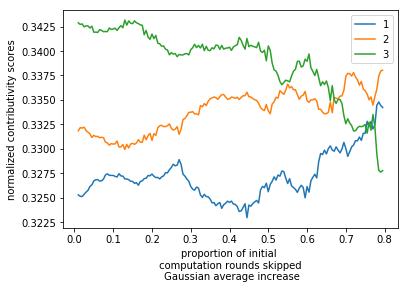

In [14]:
plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.8,0.005,0.01)

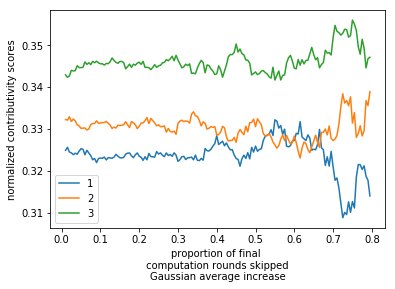

In [15]:
plot_last_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.005,0.01,0.8)

In [16]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

step = 0.05

init_comp_rounds_skipped_min = 0.01
init_comp_rounds_skipped_max = 0.8
init_comp_rounds_skipped = 0.01


final_comp_rounds_skipped_min = 0.01
final_comp_rounds_skipped_max = 0.8
final_comp_rounds_skipped = 0.01

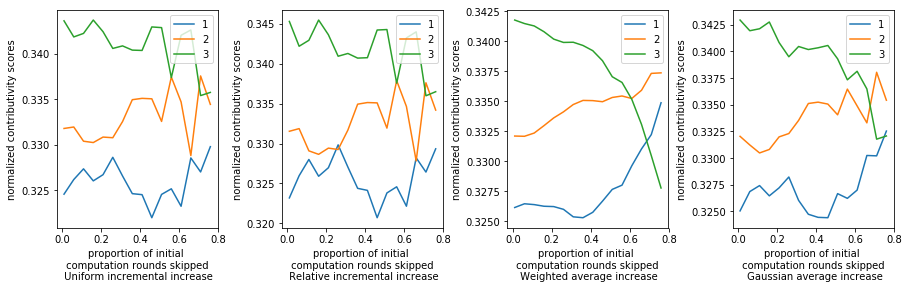

In [17]:
plot_multiple_function_init_round_skipped (score_matrix_per_partner,score_matrix_collective_models,
                             agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                                 step, final_comp_rounds_skipped)

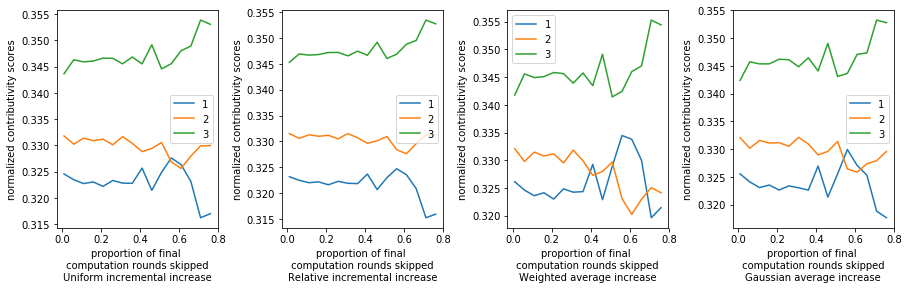

In [18]:
plot_multiple_function_last_rounds_skipped (score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

## Test on real simulations

### define parameters to test

In [20]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

step = 0.05

init_comp_rounds_skipped_min = 0.01
init_comp_rounds_skipped_max = 0.8
init_comp_rounds_skipped = 0.01


final_comp_rounds_skipped_min = 0.01
final_comp_rounds_skipped_max = 0.8
final_comp_rounds_skipped = 0.01

### define scenarios

In [45]:
scenario_name = df.scenario_name.iloc[0]
sh_scenario_name = str(df.aggregation_weighting.iloc[0] + " "+ df.short_scenario_name.iloc[0] + " " + df.samples_split_option.iloc[0])
scenario_path = experiment_path / scenario_name
history_data_path = scenario_path / "history_data.p"

In [46]:
with open(history_data_path, 'rb') as f:
    loss_data = pickle.load(f)

In [47]:
score_matrix_per_partner = loss_data["score_matrix_per_partner"]
score_matrix_collective_models = loss_data["score_matrix_collective_models"]

early_stop_epoch = int(df.mpl_nb_epochs_done.iloc[0])
score_matrix_per_partner = score_matrix_per_partner[:early_stop_epoch,:,:]
score_matrix_collective_models = score_matrix_collective_models [:early_stop_epoch, :]

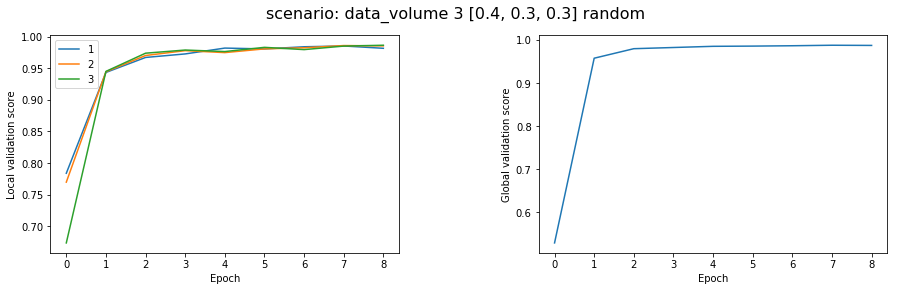

In [48]:
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

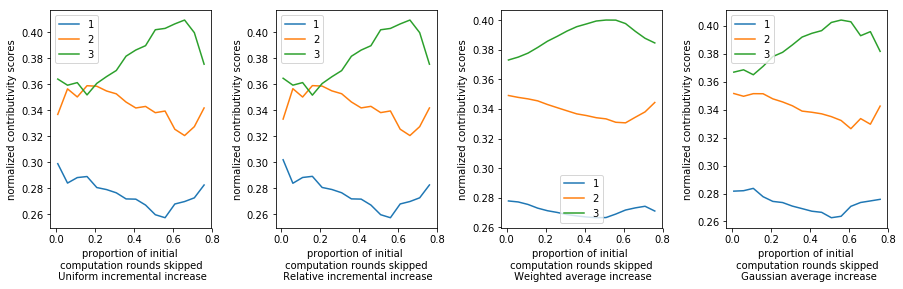

In [49]:
plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

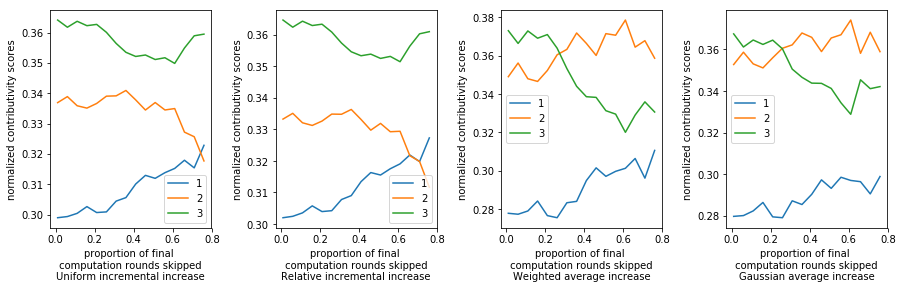

In [50]:
plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [57]:
def define_scenario (scenario_num):
    scenario_name = df.scenario_name.iloc[scenario_num]
    sh_scenario_name = str(df.aggregation_weighting.iloc[scenario_num] + " "+ df.short_scenario_name.iloc[scenario_num] + " " + df.samples_split_option.iloc[scenario_num])
    scenario_path = experiment_path / scenario_name
    history_data_path = scenario_path / "history_data.p"
    
    with open(history_data_path, 'rb') as f:
        loss_data = pickle.load(f)
    
    score_matrix_per_partner = loss_data["score_matrix_per_partner"]
    score_matrix_collective_models = loss_data["score_matrix_collective_models"]

    early_stop_epoch = int(df.mpl_nb_epochs_done.iloc[scenario_num])
    score_matrix_per_partner = score_matrix_per_partner[:early_stop_epoch,:,:]
    score_matrix_collective_models = score_matrix_collective_models [:early_stop_epoch, :]
    
    
    return score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name
    

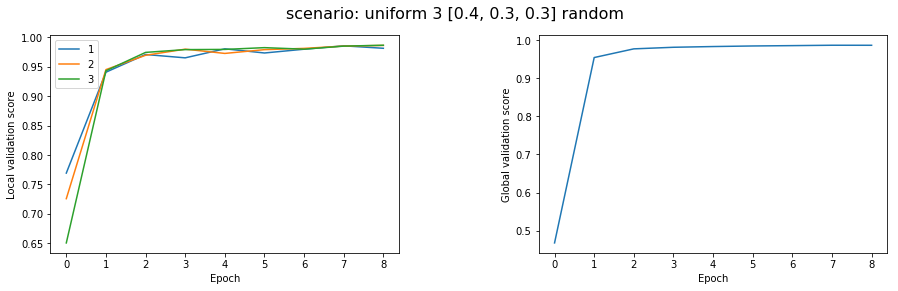

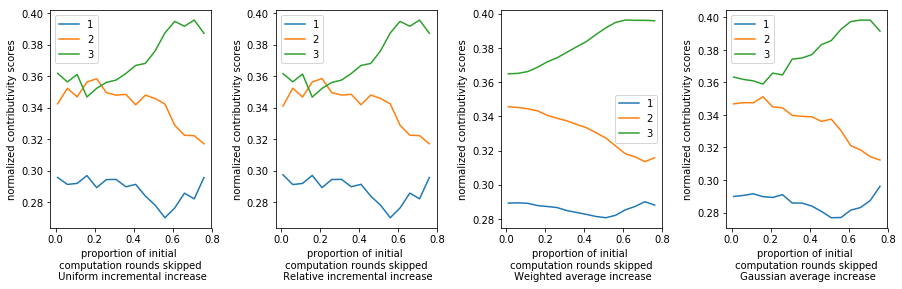

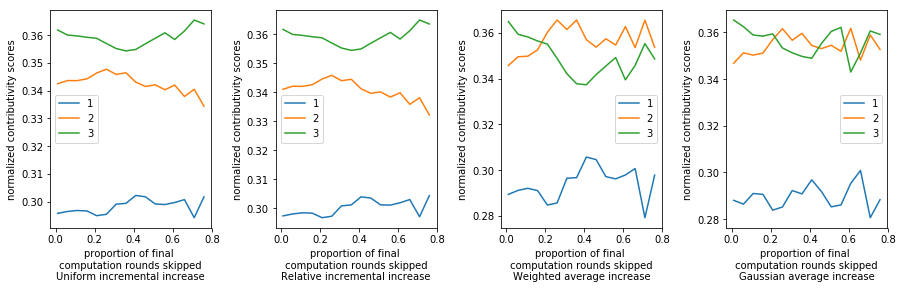

In [63]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (1)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

[[[ 0.23449999  0.141       0.08250001]
  [-0.12391669 -0.22191668 -0.24700001]
  [-0.05691665 -0.16458333 -0.17033333]
  [-0.17616668 -0.27516669 -0.28100002]
  [-0.06899998 -0.11025    -0.17491665]
  [-0.21091664 -0.32074997 -0.32749996]
  [-0.07750002 -0.11191666 -0.18316668]
  [-0.25608331 -0.36791664 -0.36341664]
  [-0.12333336 -0.18083337 -0.2244167 ]
  [-0.30783334 -0.42416668 -0.41608334]
  [-0.16933334 -0.21516669 -0.27358335]
  [-0.37375    -0.48691666 -0.47641665]
  [-0.16983336 -0.1956667  -0.27333334]
  [-0.36658332 -0.47433335 -0.47716665]
  [-0.19591668 -0.21533334 -0.29508334]
  [-0.36408335 -0.46266666 -0.46141666]
  [-0.2048333  -0.18791664 -0.30783331]
  [-0.4075     -0.505      -0.51308334]
  [-0.27166665 -0.29558331 -0.38133332]
  [-0.41666666 -0.50999999 -0.52433333]]

 [[-0.26324999 -0.25999999 -0.36433333]
  [-0.41791666 -0.50966665 -0.52466667]
  [-0.26875001 -0.22741669 -0.37666669]
  [-0.43924996 -0.5243333  -0.54349998]
  [-0.29708335 -0.30375001 -0.39991668

ValueError: operands could not be broadcast together with shapes (7,20,3) (7,3) 

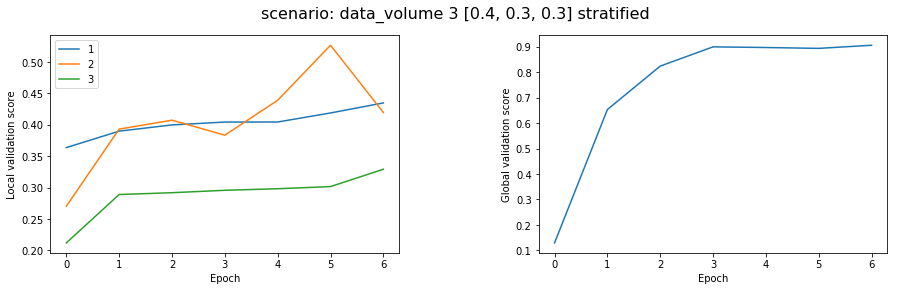

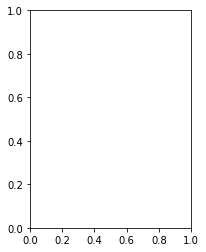

In [88]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (2)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

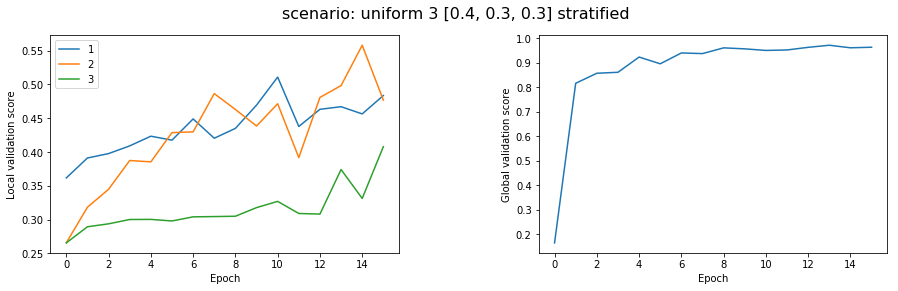

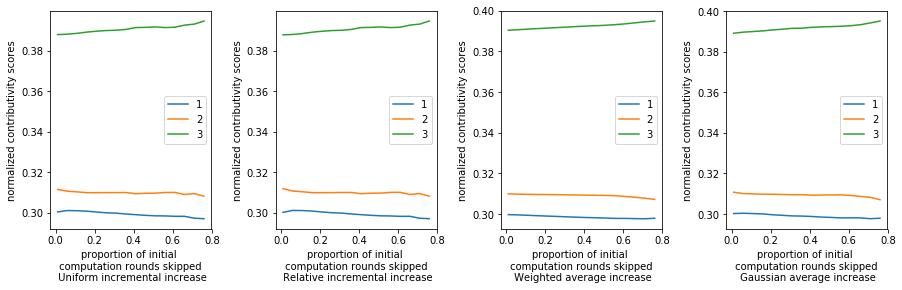

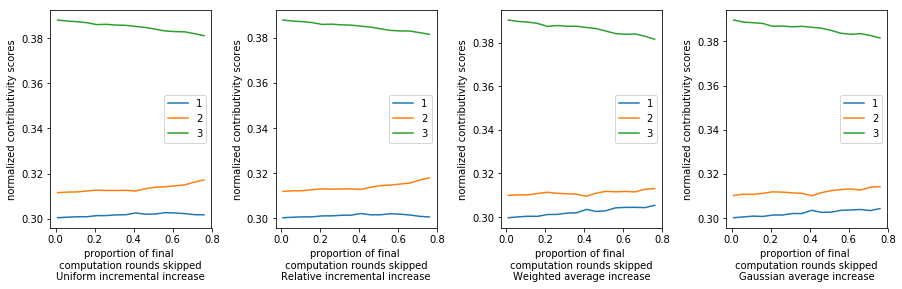

In [65]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (3)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

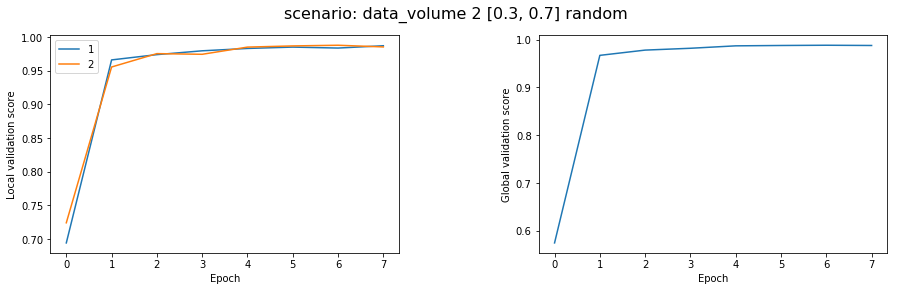

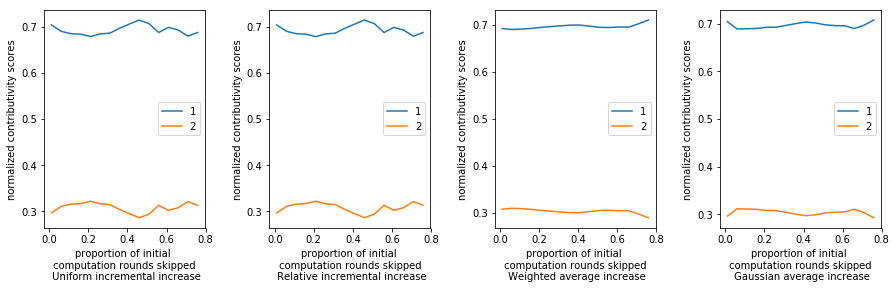

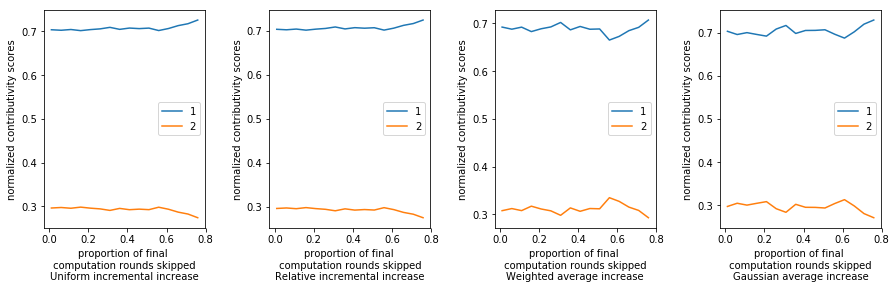

In [66]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (4)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

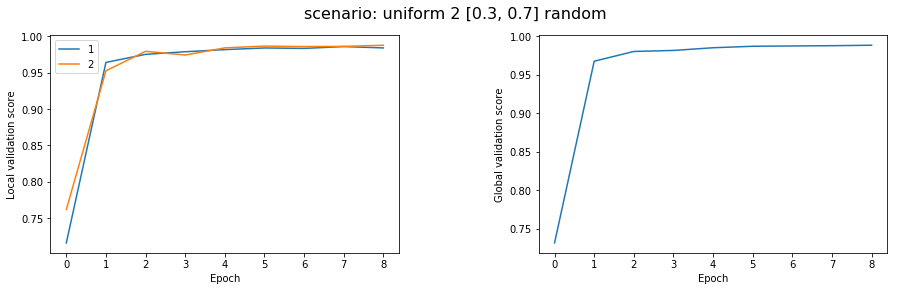

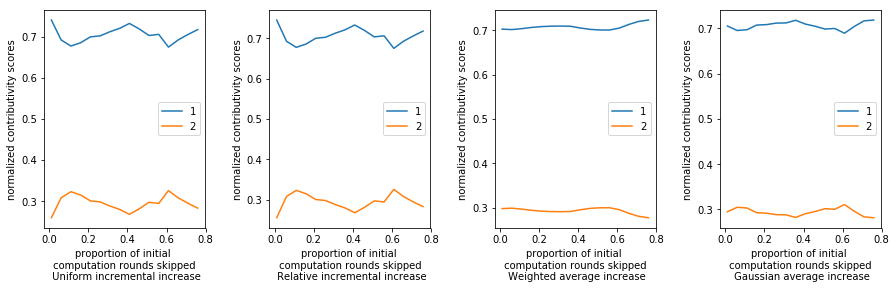

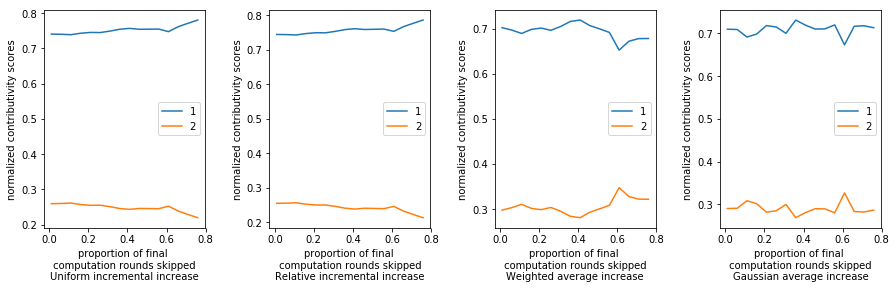

In [67]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (5)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

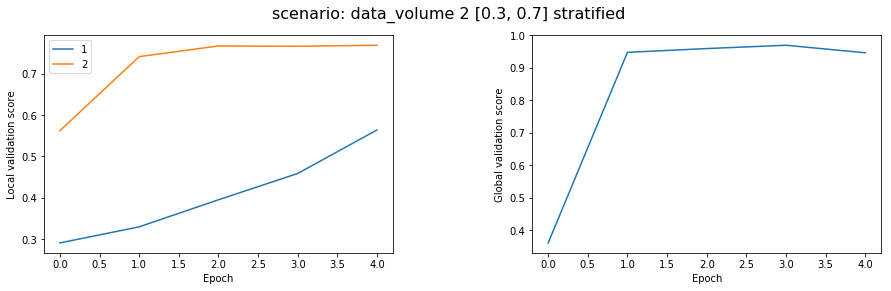

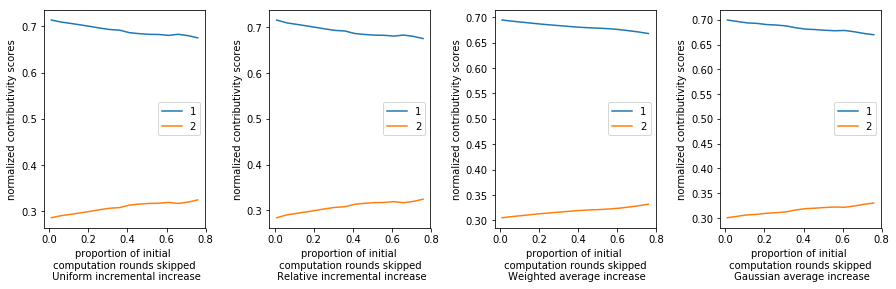

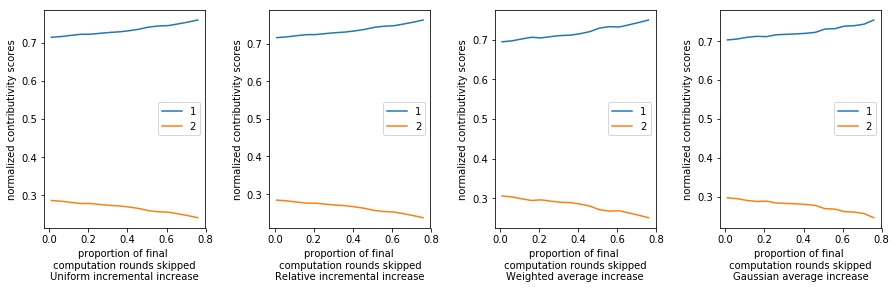

In [68]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (6)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

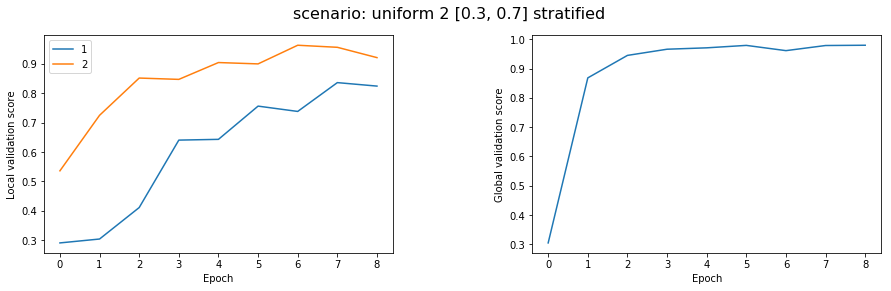

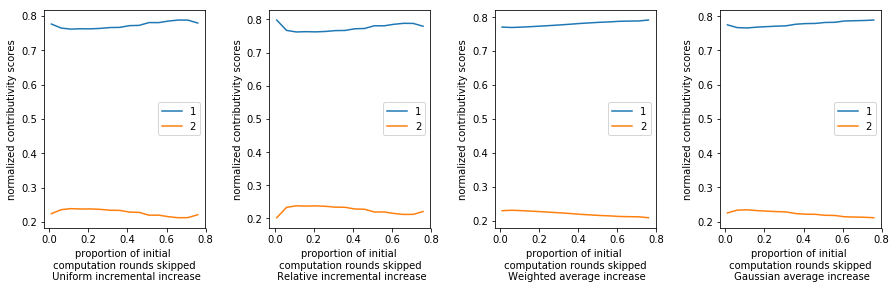

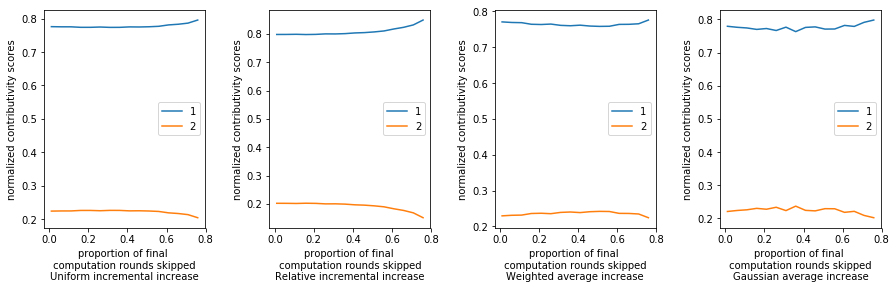

In [69]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (7)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

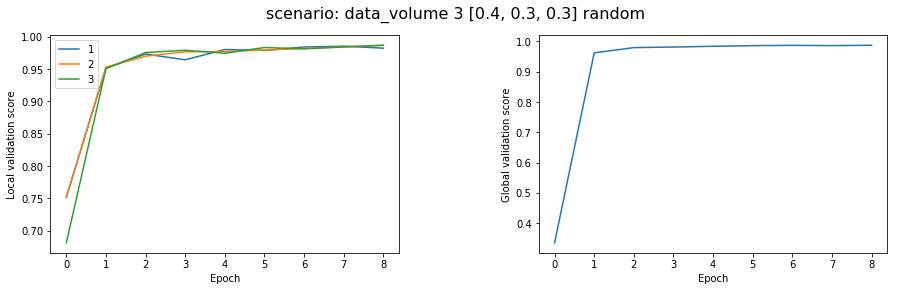

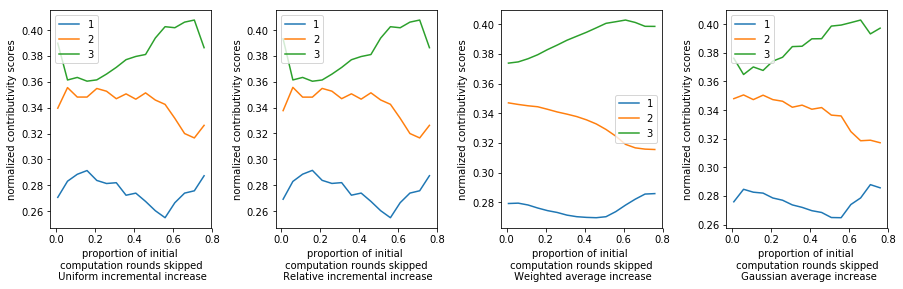

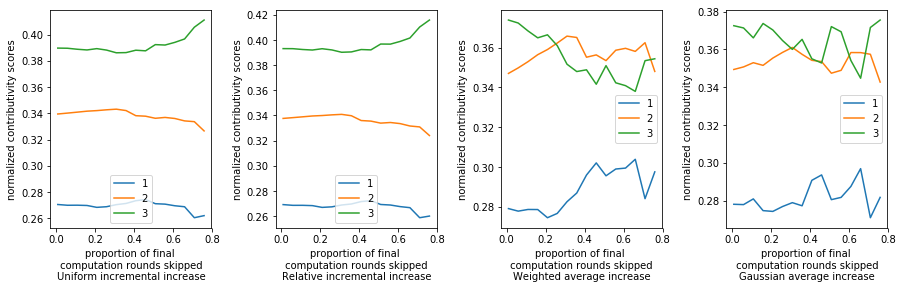

In [70]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (8)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

[[[ 4.19249982e-01  4.13750023e-01  3.10000032e-01]
  [-5.06666899e-02 -4.34166789e-02 -3.30833793e-02]
  [-4.85833287e-02 -2.35833526e-02 -5.65000176e-02]
  [-4.53333259e-02 -7.98333287e-02 -4.51666713e-02]
  [-3.74166369e-02 -3.89166474e-02 -1.42499804e-02]
  [-1.48333311e-02 -2.00833082e-02 -5.01666665e-02]
  [-1.60000324e-02 -1.37500167e-02 -2.85833478e-02]
  [-5.83332777e-03 -3.33333015e-02 -3.33333015e-02]
  [-2.74167061e-02 -2.67500281e-02 -6.74998760e-03]
  [-6.41667843e-03 -3.79166603e-02 -3.11666727e-02]
  [-1.19166970e-02 -7.49999285e-03 -2.01666951e-02]
  [-2.89999843e-02 -9.75000858e-03 -2.81666517e-02]
  [-1.51666999e-02 -3.16666961e-02 -1.79166794e-02]
  [-1.62500143e-02 -1.84166431e-02 -2.20833421e-02]
  [-1.09999776e-02 -1.22500062e-02 -2.24166512e-02]
  [-1.32499933e-02 -1.80833340e-02 -1.11666918e-02]
  [-1.74999833e-02 -1.50833130e-02 -9.99999046e-03]
  [-1.08331442e-03 -3.55833173e-02 -9.75000858e-03]
  [-6.83331490e-03 -2.91669369e-03 -2.16666460e-02]
  [-1.033329

ValueError: operands could not be broadcast together with shapes (9,20,3) (9,3) 

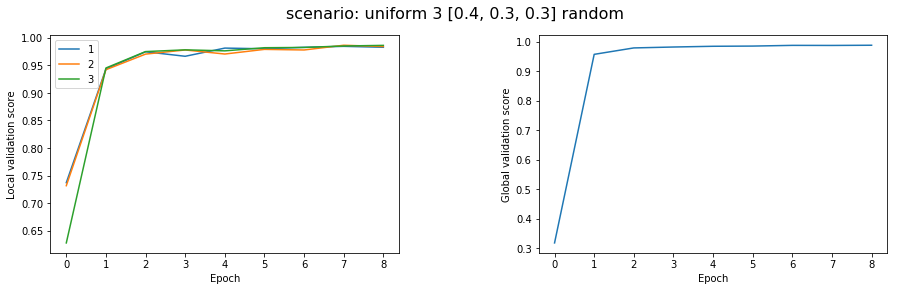

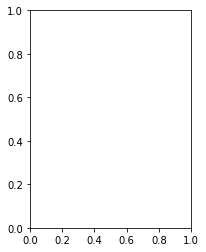

In [90]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (9)
plot_validation_scores(score_matrix_per_partner,score_matrix_collective_models, sh_scenario_name)

plot_multiple_function_init_round_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         agg_functions, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

plot_multiple_function_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_functions, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [93]:
score_matrix_per_partner , score_matrix_collective_models  , sh_scenario_name = define_scenario (3)

In [94]:
score_matrix_per_partner

array([[[0.36158332, 0.26550001, 0.26533332],
        [0.35991666, 0.264     , 0.26791668],
        [0.37516665, 0.25975001, 0.26199999],
        [0.37266666, 0.34358335, 0.26833335],
        [0.37866667, 0.27466667, 0.26800001],
        [0.38133332, 0.35391667, 0.27891666],
        [0.36608332, 0.27716666, 0.27625   ],
        [0.38416666, 0.35249999, 0.2595    ],
        [0.37775001, 0.27841666, 0.27458334],
        [0.38866666, 0.35083333, 0.27883333],
        [0.37733334, 0.27866668, 0.27658334],
        [0.38216665, 0.34491667, 0.28458333],
        [0.37858334, 0.28966665, 0.28308332],
        [0.38966668, 0.35824999, 0.28799999],
        [0.38133332, 0.28200001, 0.28666666],
        [0.38966668, 0.35916665, 0.28099999],
        [0.38891667, 0.34241667, 0.26958334],
        [0.38683334, 0.36491665, 0.28349999],
        [0.38716668, 0.3405    , 0.287     ],
        [0.39199999, 0.36583334, 0.27141666]],

       [[0.39108333, 0.31816667, 0.28924999],
        [0.39324999, 0.36524999,